In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from types import SimpleNamespace as SN
from IPython.core.display import Image, display
import os
import sys

np.random.seed(14)

In [2]:
# Set the checkpoint path
n_agents = 5

path = '/Users/mika/Downloads/models/qmix__2s3z__2019-07-11_22-34-41'

timestep = '10001710'

In [3]:
# Copied from refactor

class QMixer(nn.Module):
    def __init__(self, args):
        super(QMixer, self).__init__()

        self.args = args
        self.n_agents = args.n_agents
        self.state_dim = int(np.prod(args.state_shape))

        self.embed_dim = args.mixing_embed_dim

        self.hyper_w_1 = nn.Linear(self.state_dim, self.embed_dim * self.n_agents)
        self.hyper_w_final = nn.Linear(self.state_dim, self.embed_dim)

        # Initialise the hyper networks with a fixed variance, if specified
        if self.args.hyper_initialization_nonzeros > 0:
            std = self.args.hyper_initialization_nonzeros ** -0.5
            self.hyper_w_1.weight.data.normal_(std=std)
            self.hyper_w_1.bias.data.normal_(std=std)
            self.hyper_w_final.weight.data.normal_(std=std)
            self.hyper_w_final.bias.data.normal_(std=std)

        # Initialise the hyper-network of the skip-connections, such that the result is close to VDN
        if self.args.skip_connections:
            self.skip_connections = nn.Linear(self.state_dim, self.args.n_agents, bias=True)
            self.skip_connections.bias.data.fill_(1.0)  # bias produces initial VDN weights

        # State dependent bias for hidden layer
        self.hyper_b_1 = nn.Linear(self.state_dim, self.embed_dim)

        # V(s) instead of a bias for the last layers
        self.V = nn.Sequential(nn.Linear(self.state_dim, self.embed_dim),
                               nn.ReLU(),
                               nn.Linear(self.embed_dim, 1))

    def forward(self, agent_qs, states):
        bs = agent_qs.size(0)
        states = states.reshape(-1, self.state_dim)
        agent_qs = agent_qs.view(-1, 1, self.n_agents)
        # First layer
        w1 = th.abs(self.hyper_w_1(states))
        b1 = self.hyper_b_1(states)
        w1 = w1.view(-1, self.n_agents, self.embed_dim)
        b1 = b1.view(-1, 1, self.embed_dim)
        hidden = F.elu(th.bmm(agent_qs, w1) + b1)
        # Second layer
        w_final = th.abs(self.hyper_w_final(states))
        w_final = w_final.view(-1, self.embed_dim, 1)
        # State-dependent bias
        v = self.V(states).view(-1, 1, 1)
        # Skip connections
        s = 0
        if self.args.skip_connections:
            ws = th.abs(self.skip_connections(states)).view(-1, self.n_agents, 1)
            s = th.bmm(agent_qs, ws)
        # Compute final output
        y = th.bmm(hidden, w_final) + v + s
        # Reshape and return
        q_tot = y.view(bs, -1, 1)
        return q_tot


In [4]:
# load checkpoint mixer

args = pickle.load(open('args.pkl', 'rb'))

mixer = QMixer(args)
mixer.load_state_dict(th.load("{}/{}/mixer.th".format(path, timestep), map_location=lambda storage, loc: storage))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
# load the episode sample
qvals, avail_actions, chosen_qvals, qtots, states, actions = pickle.load(open('info.pkl', 'rb'))

In [6]:
tmp = qvals[0]

min_val = th.min(qvals).item()
max_val = th.max(qvals).item()
print(min_val, max_val)

-0.4345519244670868 0.40445321798324585


In [7]:
length = len(qtots[0])

def get_saliency(i):
    input_qvals = chosen_qvals[:, i,:]
    
    input_state = states[:, i,:]
    output_qtot = mixer(input_qvals, input_state)
    
    input_qvals.retain_grad()
    output_qtot.backward(retain_graph=True)
    return input_qvals.grad.data[0].numpy()

#for i in range(length):
#    print(get_saliency(i))

In [8]:
def action_string(a_id, action):
    n_actions_no_attack = 6
    act_str = {
        0: "Agent %d: Dead"% a_id,
        1: "Agent %d: Stop"% a_id,
        2: "Agent %d: North"% a_id,
        3: "Agent %d: South"% a_id,
        4: "Agent %d: East"% a_id,
        5: "Agent %d: West"% a_id,
    }
    if action < n_actions_no_attack:
        return act_str[action]
    else:
        target_id = action - n_actions_no_attack
        return "Agent %d attacks enemy # %d" % (a_id, target_id)

In [9]:
import matplotlib as mpl
import matplotlib.cm as cm

cmap = cm.Blues
print(cm)

def get_color(x, vmin=-1, vmax=1):
    m = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
    vals = list(m.to_rgba(x)[:3])
    for i in range(len(vals)):
        vals[i] *= 255
    return tuple(vals)

from IPython.display import HTML as html_print

def cstr(s, r=255, g=0, b=0, underline=False):
    u = ""
    if underline:
        return "<text style=background-color:rgb({},{},{})><u>{}</u></text>".format(r,g,b,s)
    else:
        return "<text style=background-color:rgb({},{},{})>{}</text>".format(r,g,b,s)
    
def show_image(num):
    num += 1
    if num < 10:
        num = '0' + str(num)
    #return '3m_screenshots/sc{}.png'.format(num)
    display(Image(filename='screenshots/sc{}.png'.format(num), width=500, unconfined=True))
    
def show_image_html(num):
    num += 1
    if num < 10:
        num = '0' + str(num)
    return "<img src=\"screenshots/sc{}.png\" width=\"500\">".format(num)

def th_html(string):
    return "<th>" + string + "</th>"

def tr_html(string):
    return "<tr>" + string + "</tr>"

def get_title_row():
    actions = ["", "Noop", "Stop", "North", "South", "East", "West"] + ["E" + str(i) for i in range(n_agents)] + ["dQtot/dQ"]
    string = "".join([th_html(a) for a in actions])
    return tr_html(string)

<module 'matplotlib.cm' from '/Users/mika/anaconda3/lib/python3.7/site-packages/matplotlib/cm.py'>


In [10]:
x = ""
for i in range(-20, 20):
    r,g,b = get_color(i, vmin = -20, vmax=20)
    x += cstr("M", r,g,b)
    
html_print(x)

In [11]:
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=np.inf)
%matplotlib inline

qvals_masked = qvals.clone()
qvals_masked[avail_actions == 0] = -np.inf

string = ""
for step in range(length):
    string += " Step {} ".format(step).center(70, '-')
    string += "<table>"
    string += get_title_row()
    saliency_vector = get_saliency(step)
    for a in range(n_agents):
        string += "<tr><th>Q[{}]</th>".format(a)
        for q in qvals_masked[0][step][a].detach().numpy():
            underline = False
            if q == max(qvals_masked[0][step][a].detach().numpy()):
                underline = True
            r,g,b = get_color(q, min_val, max_val)
            val = "{:.3f}".format(q)
            string += "<th>" + cstr(val, r, g, b, underline) + '</th>'
        
        if qvals_masked[0][step][a].detach().numpy()[0] != -np.inf:
            r,g,b = 255,0,0
        else:
            r,g,b = 255,255,255
        string += "<th>" + cstr(" S[{}]={:.2f}".format(a, saliency_vector[a]), r,g,b) + '</th>'
        string += "</tr>"
    string += "</table>"
    string += "<br /> Q_tot = {:.3f}".format(qtots[0][step].detach().numpy()[0])
    string += show_image_html(step)
    
html_print(string)

,Noop,Stop,North,South,East,West,E0,E1,E2,E3,E4,dQtot/dQ
Q[0],-inf,0.002,0.020,0.027,-0.021,-0.021,-inf,-inf,-inf,-inf,-inf,S[0]=0.37
Q[1],-inf,0.005,0.057,0.013,-0.028,-0.019,-inf,-inf,-inf,-inf,-inf,S[1]=0.31
Q[2],-inf,0.004,0.085,-0.015,-0.025,-0.023,-inf,-inf,-inf,-inf,-inf,S[2]=0.57
Q[3],-inf,-0.003,0.070,-0.029,-0.037,-0.041,-inf,-inf,-inf,-inf,-inf,S[3]=0.68
Q[4],-inf,0.001,0.065,-0.015,-0.040,-0.036,-inf,-inf,-inf,-inf,-inf,S[4]=0.52
,Noop,Stop,North,South,East,West,E0,E1,E2,E3,E4,dQtot/dQ
Q[0],-inf,-0.212,-0.232,-0.236,-0.155,-0.238,-inf,-inf,-inf,-inf,-inf,S[0]=0.17
Q[1],-inf,-0.212,-0.227,-0.266,-0.170,-0.262,-inf,-inf,-inf,-inf,-inf,S[1]=0.30
Q[2],-inf,-0.213,-0.197,-0.283,-0.169,-0.269,-inf,-inf,-inf,-inf,-inf,S[2]=0.25
Q[3],-inf,-0.218,-0.198,-0.295,-0.184,-0.280,-inf,-inf,-inf,-inf,-inf,S[3]=0.54


In [12]:
# Qtot dependency on Qi
import matplotlib.pyplot as plt
step = 33
agent = 0

def plot_dependency(step, agent, num_points=10, min_val=min_val, max_val=max_val):
    input_qvals = chosen_qvals[:, step,:]
    input_state = states[:, step,:]
    
    original_val = input_qvals[0][agent].detach().numpy()
    output_qtot = mixer(input_qvals, input_state).item()
    print("Original Q[{}] = {:.3f}. Qtot = {:.3f}. (Min = {:.3f}, Max = {:.3f})".format(
        agent, original_val, output_qtot, min_val, max_val))
    
    xlist = []
    ylist = []
    for i in np.arange(min_val, max_val, (max_val - min_val) / num_points):
        xlist.append(i)
        input_qvals[0][agent] = i
        new_qtot = mixer(input_qvals, input_state)
        ylist.append(new_qtot)
    
    plt.plot(xlist, ylist, 'bo')

Original Q[0] = -0.256. Qtot = 6.701. (Min = -0.435, Max = 0.404)


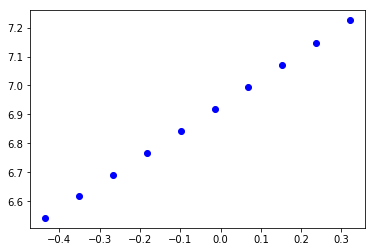

In [13]:
plot_dependency(33, 0)

Original Q[1] = -0.194. Qtot = 7.225. (Min = -0.435, Max = 0.404)


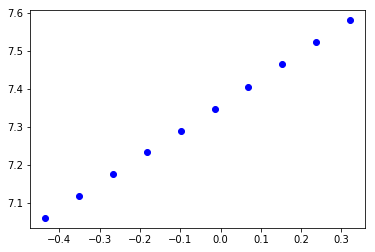

In [14]:
plot_dependency(33, 1)

Original Q[2] = -0.221. Qtot = 4.372. (Min = -0.435, Max = 0.404)


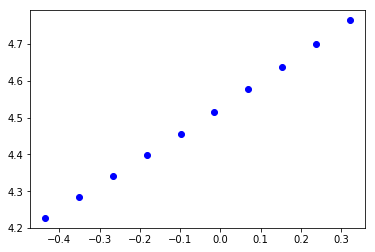

In [15]:
plot_dependency(41, 2)

Original Q[4] = -0.177. Qtot = 16.807. (Min = -0.435, Max = 0.404)


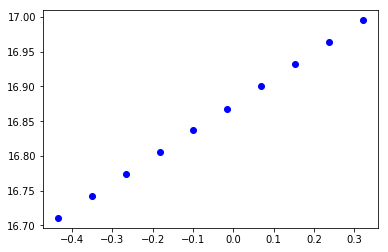

In [16]:
plot_dependency(1, 4)

Original Q[0] = -0.155. Qtot = 16.995. (Min = -0.435, Max = 0.404)


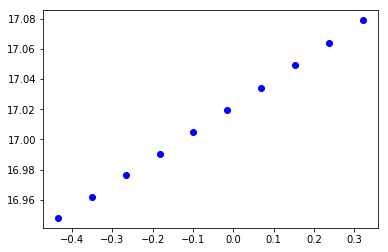

In [17]:
plot_dependency(1, 0)

Original Q[0] = 0.027. Qtot = 16.800. (Min = -2.000, Max = 2.000)


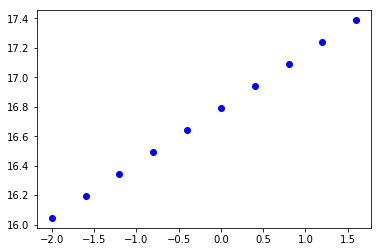

In [18]:
plot_dependency(0, 0, min_val = -2, max_val = 2)

In [19]:
agent = 0
ts = 0
new_mixer = QMixer(args)

def integrated_grad(ts, agent, baseline=0, steps=100):
    
    input_qvals = chosen_qvals[:, ts,:]
    input_state = states[:, ts,:]
    
    output_qtot = new_mixer(input_qvals, input_state)
    
    input_qvals.retain_grad()
    output_qtot.backward()
    #return input_qvals.grad.data[0].numpy()
    print(input_qvals.grad.data[0].numpy())
    
print(integrated_grad(30, 0))

RuntimeError: leaf variable has been moved into the graph interior